This is a multi agent example in handling book borrow/ recommendation requests
<br>
<br>
The system features: <br>
a ChromaDB-powered recommendation agent for book suggestions <br>
a MongoDB-backed operations agent handling borrowing transactions and status tracking <br>
a membership management agent that processes new member registrations when non-members interact with the system.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    model=os.environ["AZURE_DEPLOYMENT_NAME"],
    api_version=os.environ["AZURE_API_VERSION"],
    temperature=0,
    model_name = "gpt-4o",
    max_tokens=512,
    timeout=None,
    max_retries=2,
    streaming = True,
    tiktoken_model_name = "gpt-4o"
)

## Setup Task Classifier

In [3]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage, trim_messages, BaseMessage

from typing import List

trimmer = trim_messages(
    max_tokens=10000,
    strategy="last",
    token_counter=llm,
    include_system=True,
)


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }


def create_classifier(llm: AzureChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role. And get the name of the person",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            "person": {
                    'type': 'string',
                    'description': 'Name of the person'
                }
            },
                
            "required": ["next", "person"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | trimmer
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )


classifier_agent = create_classifier(
    llm,
    """
    You are a classifier tasked with managing a conversation between the
    following workers:  Recommend, Operation. 
    The main duty of Recommend agent is to provide a short summary of a book requested by user.
    While the main duties of Operation agent is to help users to borrow books
    and provide users book borrowing status.
    Given the following user request,
    respond with the worker to act next. Each worker will perform a
    task and respond with their results and status. When finished,
    respond with FINISH.
    """,
    ["Recommend", "Operation"],
)

C:\Users\Sam Cheng\AppData\Local\Temp\ipykernel_14044\3857829403.py:62: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 0.3.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


In [5]:
"Test classifier agent"
classifier_agent.invoke({"messages": [("user", "I am Sam and I want to borrow the book Animal Farm")]})

{'next': 'Operation', 'person': 'Sam'}

## Define Function Tools for Workers

In [8]:
from langchain_core.tools import tool
from pymongo import MongoClient
from datetime import datetime, timedelta

@tool
def update_record(person: str, bookname: str, action: str) -> str:
    """
    This is a funciton to update the borrowing status of books and person.
    There are only two actions: ['borrow', 'return']
    """
    client = MongoClient(host="localhost", port=27017, username=os.environ["MONGO_USER"], password=os.environ["MONGO_PASSWORD"])
    collection_books = client["Record"]["books"]
    collection_users = client["Record"]["users"]
    
    if action == "borrow":
        return_date = (datetime.now() + timedelta(days=14)).strftime("%d-%m-%Y")
    
        collection_books.update_one(
            {"BookTitle": bookname}, {"$set": {"Status": "B", "ReturnDate": return_date}}
        )
    
        collection_users.update_one(
            {"Name": person},
            {"$push": {"BorrowBooks": {"BookName": bookname, "ReturnDate": return_date}}},
        )
        # client.close()
        return (
            f"Hi {person}, {bookname} has been borrowed, the return date is {return_date}."
        )
    elif action == "return":
        collection_books.update_one(
            {"BookTitle": bookname}, {"$set": {"Status": "A", "ReturnDate": ""}}
        )
        collection_users.update_one(
            {"Name": person},
            {"$pull": {"BorrowBooks": {"BookName": bookname}}},
        )
        # client.close()
        return (
            f"Hi {person}, you have sucessfully return the book {bookname}."
            )
    else:
        return (f"The {action} is not authorised.")


@tool
def check_record(person: str) -> str:
    """
    This is a function to extract information on the status of books borrowed by users.
    """
    client = MongoClient(host="localhost", port=27017, username=os.environ["MONGO_USER"], password=os.environ["MONGO_PASSWORD"])
    collection_users = client["Record"]["users"]

    output = collection_users.find_one({"Name": person}, {"BorrowBooks": 1})

    no_book = len(output["BorrowBooks"])

    if no_book > 0:
        return f"Hi {person}, you have borrowed a total {no_book} books."
    else:
        return f"Hi {person}, you have not borrowed any books."

@tool
def add_member(person: str, decision: str) -> str:
    """
    This is a function to add membership record base on the decision of a person.
    The decision choice is either ['Yes', 'No']
    """
    if decision == "Yes":
        client = MongoClient(host="localhost", port=27017, username=os.environ["MONGO_USER"], password=os.environ["MONGO_PASSWORD"])
        collection_users = client["Record"]["users"]
    
        collection_users.insert_one({"Name": person, "BorrowBooks": []})
    
        #client.close()
        return f"Hi {person}, welcome to be a member."
    else:
        return f"Hi {person}, sorry that you cannot enjoy our service."
    

## Defien Router function

In [10]:
def check_membership(person: str) -> str:
    """
    This is a function to check the existence of user in MongoDB.
    """
    client = MongoClient(host="localhost", port=27017, username=os.environ["MONGO_USER"], password=os.environ["MONGO_PASSWORD"])
    collection_users = client["Record"]["users"]

    if collection_users.count_documents({"Name": person}) > 0:
        return True
    else:
        return False

def route_tools(state):
    """
    This is a membership routing function
    if the person is in the database, Simply return the current state.
    Otherwise, the person does not have any membership yet. The return is 'add_member_node'.
    """
    current_state = state["next"]
    if current_state == "Operation":
        person = state["person"]
        if check_membership(person):
            return current_state
        else:
            return "AddMember"
    else:
        return current_state

## Setup Agent

In [12]:
from typing import Annotated, Literal
from typing_extensions import TypedDict
import operator
import functools
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel

class WorkerState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

from langchain.prompts import PromptTemplate

operation_agent = create_react_agent(
    llm,
    tools=[update_record, check_record],
)

operation_node = functools.partial(agent_node, agent=operation_agent, name="Operation")

In [14]:
class AddMemberRoute(BaseModel):
    next: Literal["Yes", "No"]
    message: str

add_member_prompt_str = """You are an agent that analysis the willingless of a person to be a member.
                           Given the following user query, 
                           extract the name and decision from the query, and pass the information to the provided tools.
                           And route to next state based on the decision.
                        """

add_member_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", add_member_prompt_str),
            MessagesPlaceholder("messages")
        ])

add_member_agent = add_member_prompt | llm.bind_tools([add_member], tool_choice = "add_member").with_structured_output(AddMemberRoute)

In [16]:
"Test Agent"
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [18]:
"Borrow test"
inputs = {"messages": [("user", "I am Sam and I want to borrow the book Animal Farm")]}
print_stream(operation_agent.stream(inputs, stream_mode="values"))

================================ Human Message =================================

I am Sam and I want to borrow the book Animal Farm
================================== Ai Message ==================================
Tool Calls:
  update_record (call_RHYxnOdUFtMvuBN6Ea8Xm7Jj)
 Call ID: call_RHYxnOdUFtMvuBN6Ea8Xm7Jj
  Args:
    person: Sam
    bookname: Animal Farm
    action: borrow
================================= Tool Message =================================
Name: update_record

Hi Sam, Animal Farm has been borrowed, the return date is 07-12-2024.
================================== Ai Message ==================================

Hi Sam, you have successfully borrowed "Animal Farm". The return date is 07-12-2024. Enjoy your reading!


In [20]:
"Return test"
inputs = {"messages": [("user", "I am Sam and I want to return the book Animal Farm")]}
print_stream(operation_agent.stream(inputs, stream_mode="values"))

================================ Human Message =================================

I am Sam and I want to return the book Animal Farm
================================== Ai Message ==================================
Tool Calls:
  update_record (call_y2464nP68UiVygEkPxvUIwmN)
 Call ID: call_y2464nP68UiVygEkPxvUIwmN
  Args:
    person: Sam
    bookname: Animal Farm
    action: return
================================= Tool Message =================================
Name: update_record

Hi Sam, you have sucessfully return the book Animal Farm.
================================== Ai Message ==================================

Hi Sam, you have successfully returned the book "Animal Farm." If you need any further assistance, feel free to ask!


In [22]:
"check record test"
inputs = {"messages": [("user", "I am Catherine. I would like to know the status of the book I currently have borrowed.")]}
print_stream(operation_agent.stream(inputs, stream_mode="values"))

================================ Human Message =================================

I am Catherine. I would like to know the status of the book I currently have borrowed.
================================== Ai Message ==================================
Tool Calls:
  check_record (call_8MBlSyA2vz3N8v7v3nOzrsPI)
 Call ID: call_8MBlSyA2vz3N8v7v3nOzrsPI
  Args:
    person: Catherine
================================= Tool Message =================================
Name: check_record

Hi Catherine, you have not borrowed any books.
================================== Ai Message ==================================

Hi Catherine, it appears that you have not borrowed any books.


In [24]:
"Test Add Member function"
add_member_agent.invoke({"messages": [HumanMessage("I am Ken and I am willing to join.")]})

AddMemberRoute(next='Yes', message='Ken is willing to join.')

## Load Persistence Chroma VectorStore

In [26]:
from langchain.embeddings import HuggingFaceBgeEmbeddings

embeddings = HuggingFaceBgeEmbeddings(
    model_name="BAAI/bge-large-en-v1.5",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},
)

from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="Books",
    embedding_function=embeddings,
    persist_directory=os.environ["CHROMA_PRESISTENCE_DIRECTORY"],
)

## Setup Self-query Retriever

In [28]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name="Book category",
        description="The genre of the book",
        type="string",
    ),
    AttributeInfo(
        name="source",
        description="Name of the book",
        type="string",
    ),
]

document_content_description = "Metadata of a book, including book title and category."

self_retriever = SelfQueryRetriever.from_llm(
    llm,
    vector_store,
    document_content_description,
    metadata_field_info,
    search_type="similarity",
    search_kwargs={"k": 1},
)

## Setup RAG Agent

In [30]:
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

rag_system_message = """
You are a book recommendation AI assistant.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know. 
You should provide a brief summary of the book that you recommend.
Question: {question}
Context: {context}
Answer:
"""

rag_prompt = ChatPromptTemplate(
    messages=[
        ("system", rag_system_message),
    ],
    input_variables=["context", "question"],
)

qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=self_retriever,
    verbose=False,
    return_source_documents=True,
    chain_type_kwargs={"prompt": rag_prompt},
)

def recommend_node(state):
    question = state["messages"][0].content
    # Retrieval
    response = qa.invoke(question)
    return {"messages": [response["result"]]}

In [32]:
"Test RAG Agent"

query = "Just recommend me a novel."
results = qa.invoke({"query": query})
print(results["result"])

I recommend the novel "The Three Stigmata of Palmer Eldritch" by Philip K. Dick. This science fiction story is set in a future world where global warming has made Earth nearly uninhabitable, and the UN is drafting people to colonize other planets. The colonists use an illegal drug called CAN-D to escape their harsh reality through shared hallucinations. The plot thickens when a new, more addictive drug called Chew-Z is introduced by the mysterious Palmer Eldritch, leading to a complex and mind-bending struggle involving corporate espionage, precognition, and questions about the nature of reality and divinity. The novel explores themes of escapism, identity, and the human condition in a dystopian future.


## Setup Memory

In [34]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Construct Graph

In [36]:
operation_graph = StateGraph(WorkerState)
operation_graph.add_node("Recommend Node", recommend_node)
operation_graph.add_node("Operation Node", operation_node)
operation_graph.add_node("Classifier Node", classifier_agent)
operation_graph.add_node("Add Member Node", add_member_agent)

operation_graph.add_edge(START, "Classifier Node")

operation_graph.add_edge("Operation Node", END)
operation_graph.add_edge("Recommend Node", END)

operation_graph.add_conditional_edges(
    "Add Member Node",
    lambda x: x["next"],
    {"Yes": "Operation Node","No": END})

operation_graph.add_conditional_edges(
    "Classifier Node",
    route_tools,
    {"Operation": "Operation Node","Recommend": "Recommend Node", "AddMember": "Add Member Node", "FINISH": END})


app = operation_graph.compile(checkpointer = memory, interrupt_before=["Add Member Node"])

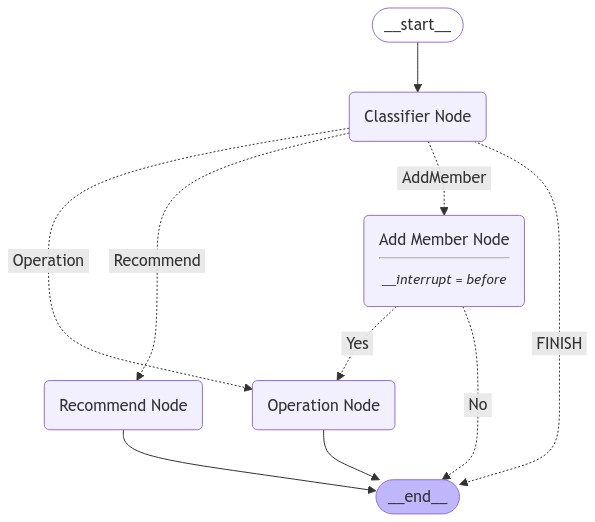

In [38]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=False).draw_mermaid_png()))

## Integration Test

In [46]:
def ParseMessage(s : dict) -> str:
    for key, value in s.items():
        if key == "__interrupt__":
            print("As you are not the member yet, Are you wailling to join?")            
        elif list(value.keys())[0] == "messages":
            try:
                message = value["messages"][-1].content
            except:
                message = value["messages"][-1]
            print(message)

        elif value["next"] == "No":
            print("Bye, see you next time.")

In [48]:
"Recommend Test"

config = {"configurable": {"thread_id": "1", "recursion_limit": 5}}

for s in app.stream({"messages": [HumanMessage(content = "I would like to read an Adventure novel. Can you recommend a book to me?")],}, 
    config
):
    if "__end__" not in s:
        ParseMessage(s)
        print("---")

---
I recommend "The Adventures of Huckleberry Finn" by Mark Twain. This classic adventure novel follows the journey of a young boy named Huck Finn as he escapes from his abusive father and travels down the Mississippi River. Along the way, he encounters various characters and faces numerous challenges, including helping a runaway slave named Jim. The novel explores themes of freedom, friendship, and the moral dilemmas of the time, making it a compelling and thought-provoking read.
---


In [50]:
"Update Borrowing Record Test"

config = {"configurable": {"thread_id": "2", "recursion_limit": 5}}

for s in app.stream({"messages": [HumanMessage(content = "I am Catherine and I want to borrow the book 'The Adventures of Huckleberry Finn'.")],},
    config,
):
    if "__end__" not in s:
        ParseMessage(s)
        print("---")

---
Hi Catherine, you have successfully borrowed "The Adventures of Huckleberry Finn". The return date is 07-12-2024. Enjoy your reading!
---


In [52]:
"Add memeber test"

config = {"configurable": {"thread_id": "3", "recursion_limit": 5}}

for s in app.stream({"messages": [HumanMessage(content = "I am Desmond and I want to borrow the book 'The Adventures of Huckleberry Finn'.")],},
    config,
):
    if "__end__" not in s:
        ParseMessage(s)
        print("---")

---
As you are not the member yet, Are you wailling to join?
---


In [54]:
app.update_state(
    config,
    {"messages": [HumanMessage(content = "I am willing to join")], "next": "AddMember"},
    as_node = "Classifier Node"
)

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa94f3-25e3-6283-8002-30a7c1ec2765'}}

In [56]:
config = {"configurable": {"thread_id": "3", "recursion_limit": 5}}

for s in app.stream(
    None ,
    config,
):
    if "__end__" not in s:
        ParseMessage(s)
        print("---")

---
Hi Desmond, you have successfully borrowed "The Adventures of Huckleberry Finn". The return date is 07-12-2024. Enjoy your reading!
---


In [58]:
"Test Summary function"

config = {"configurable": {"thread_id": "4", "recursion_limit": 5}}

for s in app.stream(
    ({"messages": [HumanMessage(content = "I am Catherine. I want to check my borrow record'.")],}),
    config,
):
    if "__end__" not in s:
        ParseMessage(s)
        print("---")

---
Hi Catherine, you have borrowed a total of 1 book.
---
